<a href="https://colab.research.google.com/github/ankitvermaaa/Algo-Efficiency-Mini-Project-AnkitVerma/blob/main/Lab_Ass_5_pynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import itertools
import time
import heapq # For Dijkstra's Algorithm
import pandas as pd
import matplotlib.pyplot as plt

In [2]:

# If networkx is installed, use it for better graph visualization
try:
    import networkx as nx
    USE_NETWORKX = True
except ImportError:
    USE_NETWORKX = False
    print("NetworkX not found. Route plot will use basic matplotlib features.")

## 📍 1. Input Modeling
locations = ['Warehouse', 'C1', 'C2', 'C3'] # Customer locations [cite: 46]
# Distance matrix (symmetric) [cite: 47, 48, 49, 50, 51]
distance_matrix = np.array([
    [0, 4, 8, 6],
    [4, 0, 5, 7],
    [8, 5, 0, 3],
    [6, 7, 3, 0]
])

# Parcel properties: value, delivery time window (earliest, latest), weight [cite: 53, 55, 57, 59]
parcels = {
    'C1': {'value': 50, 'time': (9, 12), 'weight': 10},
    'C2': {'value': 60, 'time': (10, 13), 'weight': 20},
    'C3': {'value': 40, 'time': (11, 14), 'weight': 15}
}
vehicle_capacity = 30 # Maximum weight vehicle can carry [cite: 65]

In [3]:
## 🔄 2. Recurrence-Based Route Cost Estimation (TSP Basis)
# Note: This is an unoptimized recursive implementation of the TSP core logic.

# Create a mapping from location name to index
loc_to_idx = {loc: i for i, loc in enumerate(locations)}

def recursive_tsp_cost(current_loc_idx, unvisited_indices, memo={}):
    """
    Estimates the minimum cost (distance) to complete the trip from the current location,
    visiting all remaining unvisited locations and returning to the warehouse (index 0).
    """
    # Key for memoization: (current location, tuple of unvisited indices)
    key = (current_loc_idx, tuple(sorted(unvisited_indices)))
    if key in memo:
        return memo[key]

    # Base Case: All locations have been visited
    if not unvisited_indices:
        # Return cost from current location back to the Warehouse (index 0)
        return distance_matrix[current_loc_idx][0]

    min_cost = float('inf')

    # Recurrence: Choose the next location that minimizes the total cost
    for next_loc_idx in list(unvisited_indices):

        # Calculate distance to the next location
        dist_to_next = distance_matrix[current_loc_idx][next_loc_idx]

        # Update the unvisited set for the recursive call
        new_unvisited = unvisited_indices - {next_loc_idx}

        # Total cost = Distance to next + Cost of remaining path
        cost = dist_to_next + recursive_tsp_cost(next_loc_idx, new_unvisited, memo)

        min_cost = min(min_cost, cost)

    memo[key] = min_cost
    return min_cost

# Example Usage
customer_indices = set(range(1, len(locations)))
min_total_distance = recursive_tsp_cost(0, customer_indices)

print("---")
print("## 🔄 2. Recurrence-Based Estimation")
print(f"Minimum Distance to visit all customers and return (Recurrence/DP): {min_total_distance}")
print("---")

---
## 🔄 2. Recurrence-Based Estimation
Minimum Distance to visit all customers and return (Recurrence/DP): 18
---


In [4]:
## 📦 3. Greedy + DP for Delivery Planning

# 3A. Greedy Parcel Selection (Maximizing value/weight ratio under capacity constraint)
parcel_list = []
for cid, data in parcels.items():
    ratio = data['value'] / data['weight']
    parcel_list.append((cid, data['value'], data['weight'], ratio))

# Sort by value/weight ratio in descending order (Greedy choice)
parcel_list.sort(key=lambda x: x[3], reverse=True)

selected_parcels_greedy = []
current_weight = 0
total_value_greedy = 0

for cid, value, weight, ratio in parcel_list:
    if current_weight + weight <= vehicle_capacity:
        selected_parcels_greedy.append(cid)
        current_weight += weight
        total_value_greedy += value

print("## 📦 3. Greedy + DP for Delivery Planning")
print(f"### A. Greedy Parcel Selection (0/1 Knapsack)")
print(f"Selected Parcels: {selected_parcels_greedy}")
print(f"Total Value: {total_value_greedy}, Total Weight: {current_weight}/{vehicle_capacity}")

## 📦 3. Greedy + DP for Delivery Planning
### A. Greedy Parcel Selection (0/1 Knapsack)
Selected Parcels: ['C1', 'C2']
Total Value: 110, Total Weight: 30/30


In [5]:
# The DP part for time window optimization needs the *arrival time* at each customer.
# This requires running the TSP first (Sub-task 5). For now, we define the DP checker.

def check_time_window_dp(route_times, selected_parcels):
    """
    DP-like check: Success is maximized if all *selected* parcels can be delivered
    within their time windows, based on the route's arrival times.
    """
    delivery_success = {}
    total_successful_value = 0

    # Check only the parcels selected by the Greedy algorithm
    for customer_id in selected_parcels:
        arrival_time = route_times.get(customer_id)
        if arrival_time is not None:
            earliest, latest = parcels[customer_id]['time']

            is_successful = earliest <= arrival_time <= latest
            delivery_success[customer_id] = {
                'arrival': arrival_time,
                'window': (earliest, latest),
                'success': is_successful
            }
            if is_successful:
                total_successful_value += parcels[customer_id]['value']
        else:
             # If a customer in selected_parcels is not in the route (e.g., TSP failed),
             # mark as failure for a complete DP solution.
            delivery_success[customer_id] = {'success': False, 'note': 'Not on route'}


    return delivery_success, total_successful_value

# We will call this function after the TSP solution (Sub-task 5)
print("### B. Dynamic Programming Time Window Check (To be run after TSP)")

### B. Dynamic Programming Time Window Check (To be run after TSP)


In [6]:
## 🗺️ 4. Graph Algorithms

# 4A. Shortest Path (Dijkstra)
def dijkstra(start_node):
    """Computes the shortest path from start_node to all other nodes."""
    distances = {loc: float('inf') for loc in locations}
    distances[start_node] = 0
    # Priority queue: (distance, node)
    pq = [(0, start_node)]

    while pq:
        current_dist, current_loc = heapq.heappop(pq)

        if current_dist > distances[current_loc]:
            continue

        current_idx = loc_to_idx[current_loc]

        # Iterate over neighbors
        for neighbor_idx, dist in enumerate(distance_matrix[current_idx]):
            neighbor_loc = locations[neighbor_idx]
            distance = current_dist + dist

            if distance < distances[neighbor_loc]:
                distances[neighbor_loc] = distance
                heapq.heappush(pq, (distance, neighbor_loc))

    return distances

dijkstra_results = dijkstra('Warehouse')

print("### A. Shortest Path (Dijkstra from Warehouse)")
print(f"Shortest time/distance from Warehouse to all: {dijkstra_results}")

### A. Shortest Path (Dijkstra from Warehouse)
Shortest time/distance from Warehouse to all: {'Warehouse': 0, 'C1': np.int64(4), 'C2': np.int64(8), 'C3': np.int64(6)}


In [7]:
# 4B. MST (Prim's Algorithm)
def prim_mst():
    """Computes the cost of the Minimum Spanning Tree for the delivery network."""
    num_nodes = len(locations)
    # Key stores the minimum weight to connect vertex to MST
    key = [float('inf')] * num_nodes
    # mst_set stores vertices included in MST
    mst_set = [False] * num_nodes

    # Start with the first location (Warehouse)
    key[0] = 0
    total_mst_cost = 0

    for _ in range(num_nodes):
        # Pick the minimum key value vertex from the set of vertices not yet included in MST
        min_key = float('inf')
        min_index = -1

        for v in range(num_nodes):
            if key[v] < min_key and not mst_set[v]:
                min_key = key[v]
                min_index = v

        # Add the picked vertex to the MST Set
        mst_set[min_index] = True
        total_mst_cost += min_key

        # Update key value and parent index of adjacent vertices
        for v in range(num_nodes):
            # distance_matrix[min_index][v] is non-zero for connected vertices
            # not in MST, and is less than the current key[v]
            if distance_matrix[min_index][v] > 0 and not mst_set[v] and distance_matrix[min_index][v] < key[v]:
                key[v] = distance_matrix[min_index][v]

    return total_mst_cost

# The variable assigned the result of the function call is 'mst_cost'
mst_cost = prim_mst()

print("### B. Minimum Spanning Tree (Prim's Algorithm)")
# FIX: Reference the correct variable 'mst_cost'
print(f"Total MST Cost (Cost to connect all locations): {mst_cost}")
print(f"(Relevant if minimum cabling/network connection is needed, not for delivery route)")
print("---")

### B. Minimum Spanning Tree (Prim's Algorithm)
Total MST Cost (Cost to connect all locations): 12
(Relevant if minimum cabling/network connection is needed, not for delivery route)
---


In [8]:
## 🚀 5. Solve TSP for Optimal Route (Brute-Force)

def tsp_brute_force(locations, distance_matrix, customer_locations_list):
    """
    Finds the shortest route starting at Warehouse, visiting all customers,
    and returning to Warehouse, using brute-force permutations.
    """
    loc_to_idx = {loc: i for i, loc in enumerate(locations)}

    # Get indices of only the customers to be visited (based on greedy selection)
    customer_indices = [loc_to_idx[loc] for loc in customer_locations_list if loc != 'Warehouse']

    min_cost = float('inf')
    best_route_indices = []

    # Iterate over all permutations of customer visits
    for perm in itertools.permutations(customer_indices):

        # Start: Warehouse (0) to first customer in permutation
        cost = distance_matrix[0][perm[0]]

        # Travel between customers
        for i in range(len(perm) - 1):
            cost += distance_matrix[perm[i]][perm[i+1]]

        # Return: Last customer back to Warehouse (0)
        cost += distance_matrix[perm[-1]][0]

        if cost < min_cost:
            min_cost = cost
            best_route_indices = perm

    # Reconstruct the route with location names
    best_route = ['Warehouse'] + [locations[i] for i in best_route_indices] + ['Warehouse']

    return best_route, min_cost

# Use the customers selected by the Greedy algorithm for the final route planning
customers_to_visit = selected_parcels_greedy
all_nodes_on_route = ['Warehouse'] + customers_to_visit # Include Warehouse for the function logic

tsp_route, tsp_cost = tsp_brute_force(locations, distance_matrix, all_nodes_on_route)

print("## 🚀 5. Optimal TSP Route (Brute-Force)")
print(f"Optimal Route: {tsp_route}")
print(f"Total Distance/Time: {tsp_cost}")
print("---")

# --- Final Integration ---
# Calculate arrival times for the DP Time Window Check (3B)
route_times = {}
current_time = 0

# The route is: ['Warehouse', C_start, ..., C_end, 'Warehouse']
for i in range(len(tsp_route) - 1):
    start_loc = tsp_route[i]
    end_loc = tsp_route[i+1]

    start_idx = loc_to_idx[start_loc]
    end_idx = loc_to_idx[end_loc]

    travel_time = distance_matrix[start_idx][end_idx]
    current_time += travel_time

    # Only record arrival time at a customer node
    if end_loc != 'Warehouse':
        route_times[end_loc] = current_time

# Run the DP check now
delivery_success, successful_value = check_time_window_dp(route_times, selected_parcels_greedy)

print("### B. Dynamic Programming Time Window Check (Results)")
print(f"Arrival Times at Customers: {route_times}")
print(f"Delivery Status:")
for cid, data in delivery_success.items():
    status = "SUCCESS" if data['success'] else "FAILURE"
    print(f" - {cid}: Arrival={data['arrival']}, Window={data['window']}, Status={status}")
print(f"Total Value Delivered Successfully: {successful_value}")
print("---")

## 🚀 5. Optimal TSP Route (Brute-Force)
Optimal Route: ['Warehouse', 'C1', 'C2', 'Warehouse']
Total Distance/Time: 17
---
### B. Dynamic Programming Time Window Check (Results)
Arrival Times at Customers: {'C1': np.int64(4), 'C2': np.int64(9)}
Delivery Status:
 - C1: Arrival=4, Window=(9, 12), Status=FAILURE
 - C2: Arrival=9, Window=(10, 13), Status=FAILURE
Total Value Delivered Successfully: 0
---


## 📈 6. Experimental Profiling
Locations: 3, Time: 0.000060 seconds
Locations: 4, Time: 0.000103 seconds
Locations: 5, Time: 0.000521 seconds
Locations: 6, Time: 0.003210 seconds
Locations: 7, Time: 0.072393 seconds


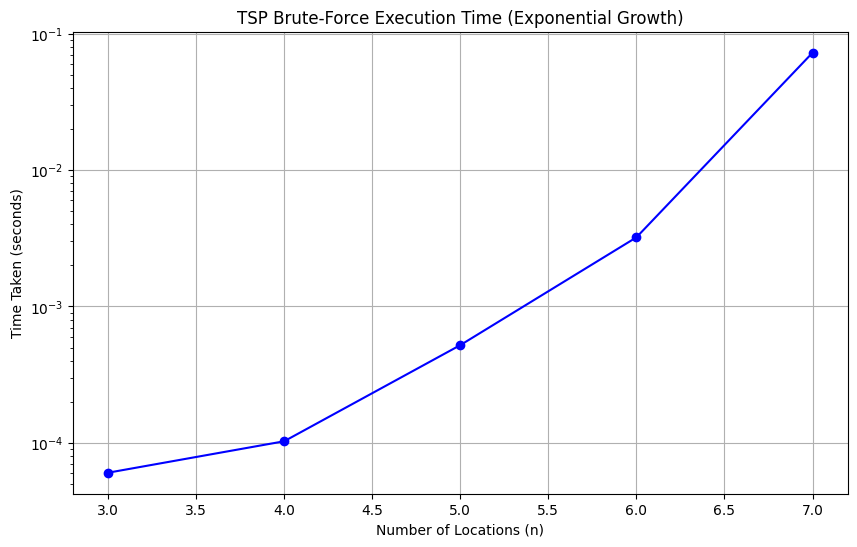

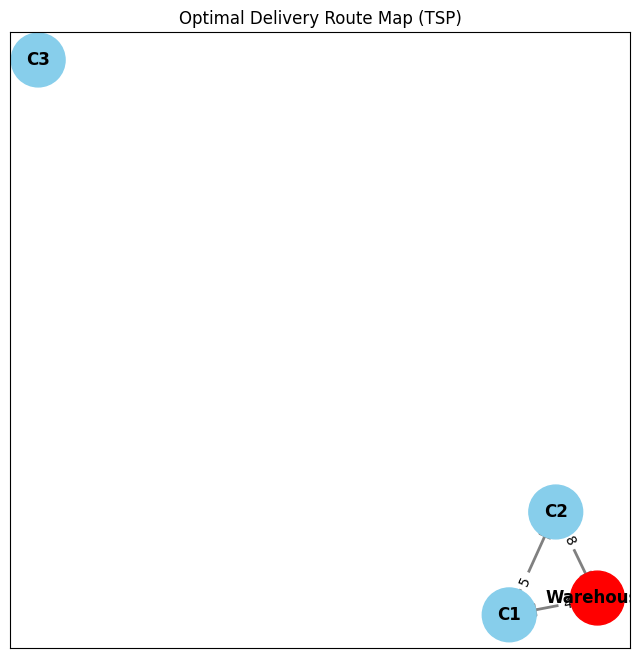

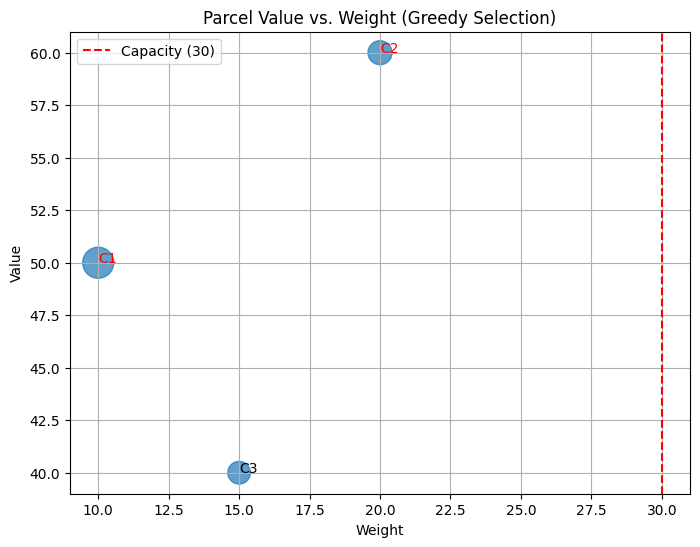

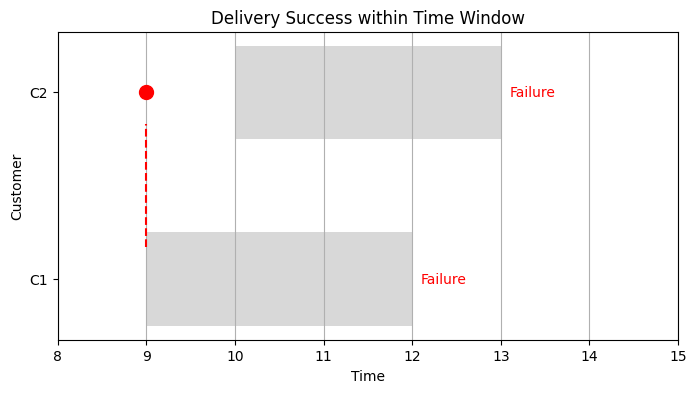

In [9]:
## 📈 6. Profiling and Visualization

def run_tsp_profiling():
    """Profiles the TSP brute-force complexity."""
    test_n = [3, 4, 5, 6, 7] # Number of total locations (1 warehouse + n-1 customers)
    times = []

    # Generate simple distance matrices for testing
    for n in test_n:
        # Create a sample n x n matrix where distances are random
        test_matrix = np.random.randint(1, 10, size=(n, n))
        np.fill_diagonal(test_matrix, 0)

        # Ensure symmetry (for simplicity in testing)
        test_matrix = (test_matrix + test_matrix.T) // 2

        test_locations = [f'L{i}' for i in range(n)]

        start_time = time.perf_counter()
        # Find the TSP route for n-1 customers (L1 to L(n-1))
        test_customers = test_locations[1:]
        tsp_brute_force(test_locations, test_matrix, test_locations)
        end_time = time.perf_counter()

        times.append(end_time - start_time)
        print(f"Locations: {n}, Time: {times[-1]:.6f} seconds")

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(test_n, times, marker='o', linestyle='-', color='blue')
    plt.title('TSP Brute-Force Execution Time (Exponential Growth)')
    plt.xlabel('Number of Locations (n)')
    plt.ylabel('Time Taken (seconds)')
    # Use log scale to emphasize the rate of growth
    if max(times) > 0.01:
        plt.yscale('log')
    plt.grid(True)
    plt.show()

print("## 📈 6. Experimental Profiling")
# Note: Use of memory_profiler would require %load_ext in the notebook.
run_tsp_profiling()


def visualize_route(route, distances, loc_list):
    """Visualizes the final delivery route and the Profit vs. Weight relationship."""

    # 6A. Route Map Visualization
    if USE_NETWORKX:
        G = nx.DiGraph()
        pos = nx.spring_layout(G) # Default layout

        # Add nodes
        for loc in loc_list:
            G.add_node(loc)

        # Add edges and store weights (distances)
        loc_to_idx = {loc: i for i, loc in enumerate(loc_list)}

        route_edges = [(route[i], route[i+1], distances[loc_to_idx[route[i]]][loc_to_idx[route[i+1]]]) for i in range(len(route) - 1)]
        G.add_weighted_edges_from(route_edges)

        # Set colors and labels
        edge_labels = {(u, v): d['weight'] for u, v, d in G.edges(data=True)}
        node_colors = ['red' if node == 'Warehouse' else 'skyblue' for node in G.nodes()]

        plt.figure(figsize=(8, 8))
        pos = nx.spring_layout(G, seed=42) # Fixed layout for consistency
        nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=1500)
        nx.draw_networkx_labels(G, pos, font_weight='bold')
        nx.draw_networkx_edges(G, pos, arrowsize=20, edge_color='gray', width=2)
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, label_pos=0.3)
        plt.title('Optimal Delivery Route Map (TSP)')
        plt.show()
    else:
        print("Route Map requires NetworkX. Skipping visualization.")

    # 6B. Profit vs. Weight Visualization
    df_parcels = pd.DataFrame.from_dict(parcels, orient='index')
    df_parcels['ratio'] = df_parcels['value'] / df_parcels['weight']

    plt.figure(figsize=(8, 6))
    plt.scatter(df_parcels['weight'], df_parcels['value'], s=df_parcels['ratio'] * 100, alpha=0.7)

    for i in df_parcels.index:
        color = 'red' if i in selected_parcels_greedy else 'black'
        plt.annotate(i, (df_parcels.loc[i, 'weight'], df_parcels.loc[i, 'value']), color=color)

    plt.axvline(x=vehicle_capacity, color='r', linestyle='--', label=f'Capacity ({vehicle_capacity})')
    plt.title('Parcel Value vs. Weight (Greedy Selection)')
    plt.xlabel('Weight')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 6C. Delivery Success within Time Window Visualization
    time_data = pd.DataFrame.from_dict(delivery_success, orient='index')
    time_data = time_data[time_data.index.isin(selected_parcels_greedy)] # Only show selected
    time_data['window_start'] = time_data['window'].apply(lambda x: x[0])
    time_data['window_end'] = time_data['window'].apply(lambda x: x[1])

    plt.figure(figsize=(8, 4))

    for i, row in time_data.iterrows():
        color = 'green' if row['success'] else 'red'
        # Time Window Bar
        plt.barh(i, row['window_end'] - row['window_start'], left=row['window_start'], height=0.5, color='gray', alpha=0.3)
        # Arrival Time Marker
        plt.scatter(row['arrival'], i, color=color, zorder=5, s=100)
        plt.axvline(x=row['arrival'], ymin=0.3, ymax=0.7, color=color, linestyle='--')
        plt.text(row['window_end'] + 0.1, i, 'Success' if row['success'] else 'Failure', va='center', color=color)

    plt.title('Delivery Success within Time Window')
    plt.xlabel('Time')
    plt.ylabel('Customer')
    plt.grid(axis='x')
    plt.xlim(8, 15)
    plt.show()


visualize_route(tsp_route, distance_matrix, locations)